In [35]:
import pandas as pd
import os
import sys
from datetime import timedelta
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

script_path = os.path.abspath(os.path.join("..", "scripts"))
sys.path.append(script_path)

import analysis_functions
import plot_functions

### Load data

In [42]:
##### LOAD DATA FROM CSV #####
df = pd.read_csv("../data/shadowtankers.csv")
df['dt']= pd.to_datetime(df['dt'], format="mixed")

### Detect possible ship to ship transfers

In [6]:
## Note: Illicit ship-to-ship transfers occur close at low speeds
## Source: https://pmc.ncbi.nlm.nih.gov/articles/PMC9785623/

# Filter to moving vessels
df_moving = df[df['sog']!=0].copy()

# Prep data
df_moving['dt']= pd.to_datetime(df_moving['dt'], format="mixed")

In [7]:
coloc_df = analysis_functions.compute_colocations(df_moving, h3_col='h3_lv7', time_buffer_hours=1)

In [8]:
coloc_df

,vessel_1,vessel_2,start,end,duration,n_colocated,n_noncolocated
0,304868000,626377000,2024-04-21 04:37:07+00:00,2024-04-21 04:37:07+00:00,0 days,1,0
1,304868000,626377000,2024-04-21 06:04:32+00:00,2024-04-21 06:04:32+00:00,0 days,1,0
2,511101363,626367000,2024-02-17 14:22:22+00:00,2024-02-17 14:22:22+00:00,0 days,1,0
3,626369000,626390000,2024-02-23 09:44:23+00:00,2024-02-23 09:44:23+00:00,0 days,1,0
4,636018350,636019784,2024-04-16 23:55:04+00:00,2024-04-16 23:55:04+00:00,0 days,1,0


In [41]:
coloc_df.to_csv("../products/3_shiptoship/possible_shadowtanker_shiptoship_events.csv",index=False)

### Generate vignettes

In [ ]:
df['geometry'] = df['geometry'].apply(wkt.loads)
df = df[df['geometry'].apply(lambda geom: geom.is_valid if geom else False)]
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

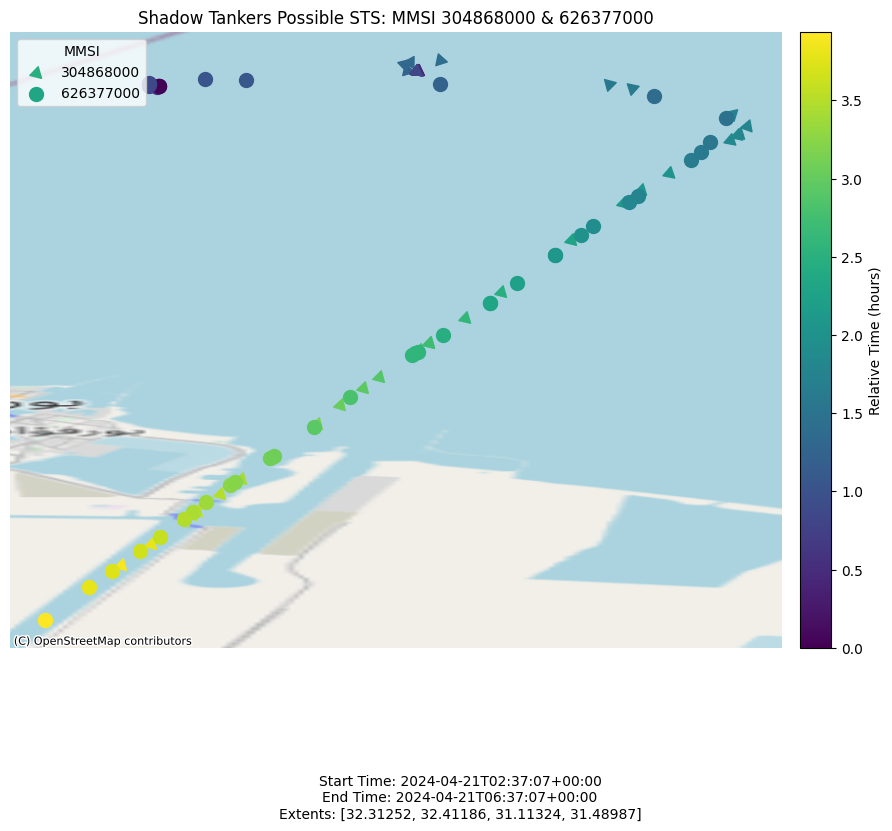

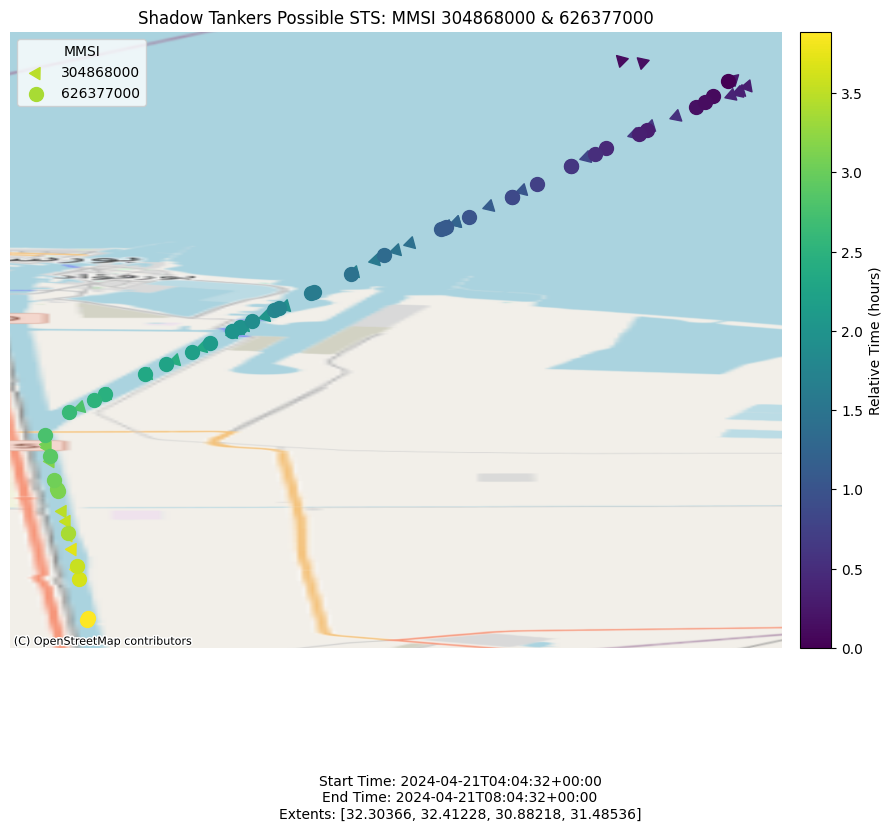

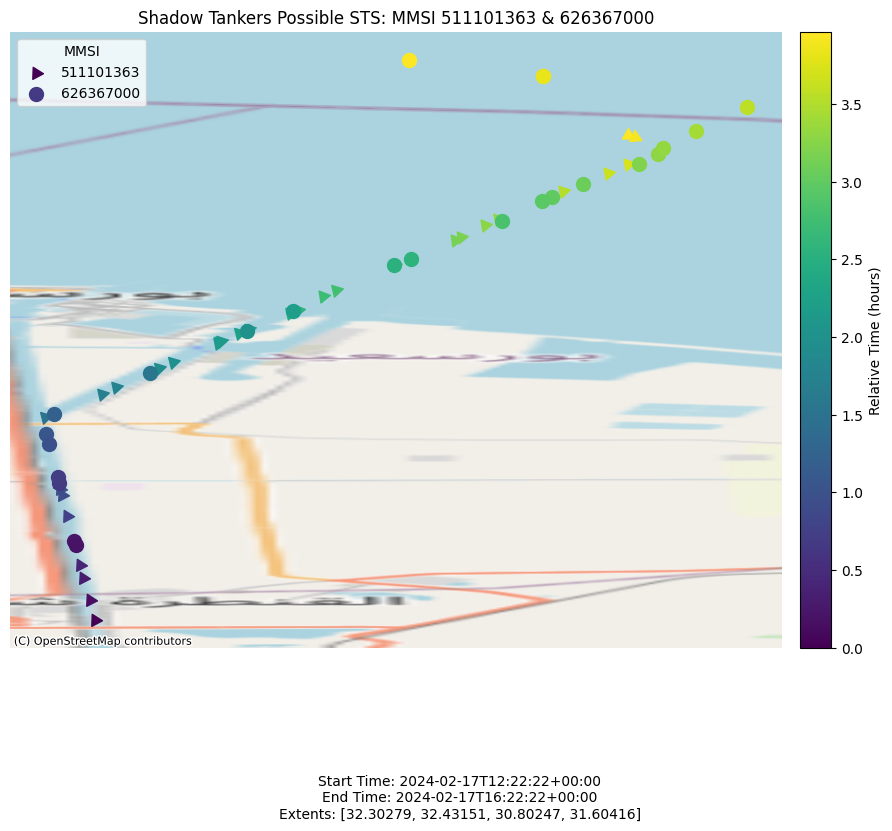

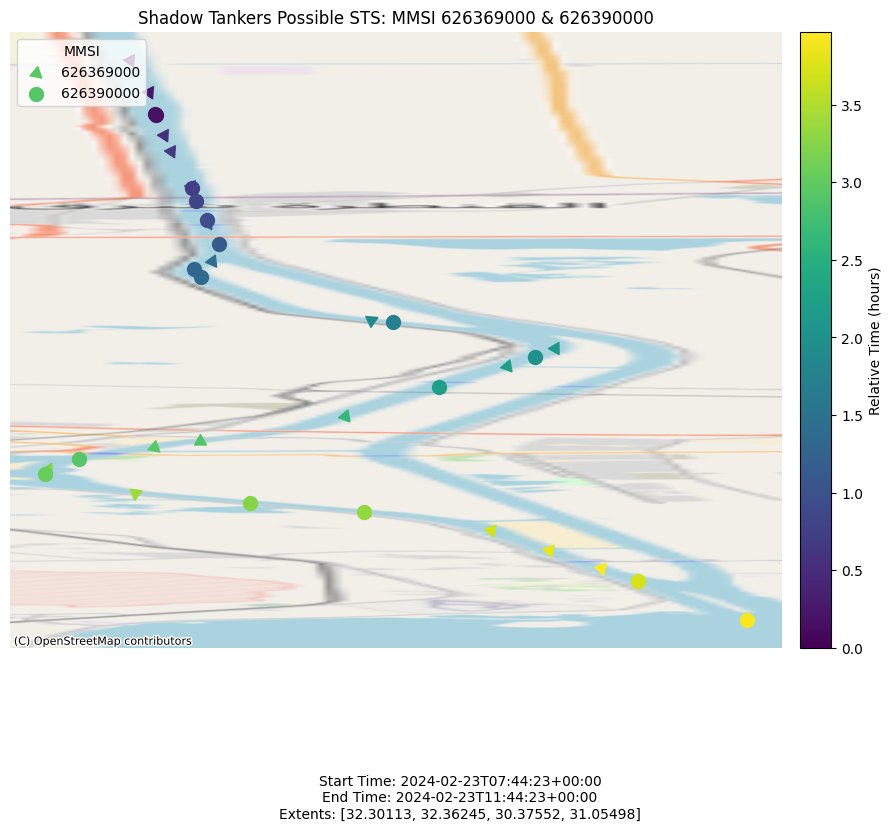

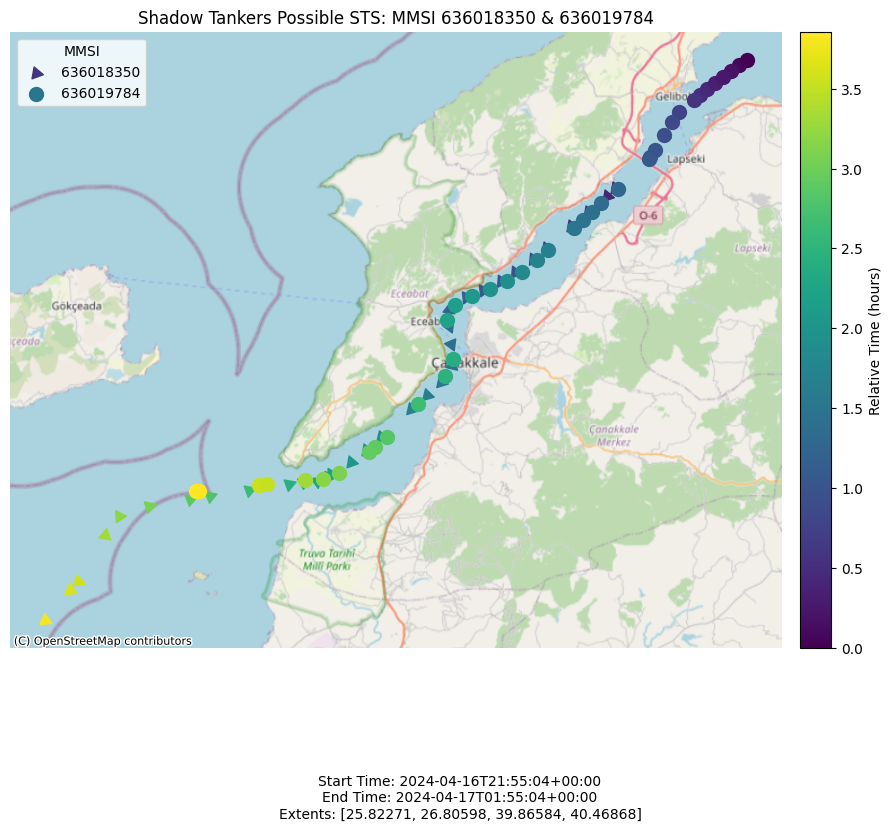

In [43]:
for i in range(0,coloc_df.shape[0]):
    vignette_row = coloc_df.iloc[i]
    mmsi_list = [vignette_row["vessel_1"], vignette_row["vessel_2"]]
    
    start_time = vignette_row["start"]-timedelta(hours=1)
    end_time = vignette_row["end"]+timedelta(hours=1)
    
    # Generate the vignette plot using the full GeoDataFrame (vessel_gdf)
    fig, ax = plot_functions.generate_vignette_plot(gdf, mmsi_list, start_time, end_time, buffer_hrs=1)
    plt.title(f"Shadow Tankers Possible STS: MMSI {mmsi_list[0]} & {mmsi_list[1]}")
    plt.gcf().canvas.draw_idle()
    plt.savefig(f"../products/3_shiptoship/shadowtankers_shiptoship_vignette_{i+1}.jpg", dpi=100)